In [1]:
import torch
from torch import nn, optim
from torchvision import datasets, transforms
import zipfile

In [2]:
torch.manual_seed(123)

In [30]:
classificador = nn.Sequential(
    nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3),
    nn.ReLU(),
    nn.BatchNorm2d(num_features=32),
    nn.MaxPool2d(kernel_size=2),
    nn.Conv2d(32, 32, 3),
    nn.ReLU(),
    nn.BatchNorm2d(32),
    nn.MaxPool2d(2),
    nn.Flatten(),
    nn.Linear(in_features=14*14*32, out_features=128),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(128, 128),
    nn.ReLU(),
    nn.Dropout(),
    nn.Linear(128, 1),
    nn.Sigmoid()

)

In [31]:
criterion = nn.BCELoss()
optimizer = optim.AdamW(classificador.parameters())

In [32]:
path = './Caes&Gatos/dataset.zip'
zip_object = zipfile.ZipFile(file=path, mode = 'r')
zip_object.extractall('./Caes&Gatos/')

In [33]:
data_dir_train = './Caes&Gatos/dataset/training_set'
data_dir_test = './Caes&Gatos/dataset/test_set'

In [34]:
transform_train = transforms.Compose(
    [
        transforms.Resize([64,64]),
        transforms.RandomHorizontalFlip(),
        transforms.RandomAffine(degrees=7, translate=(0, 0.07), shear = 0.2, scale = (1,1.2)),
        transforms.ToTensor()
    ]
)

In [35]:
transform_test = transforms.Compose(
    [
        transforms.Resize([64,64]),
        transforms.ToTensor()
    ]
)

In [36]:
train_dataset = datasets.ImageFolder(data_dir_train, transform_train)

In [37]:
train_dataset

Dataset ImageFolder
    Number of datapoints: 4000
    Root location: ./Caes&Gatos/dataset/training_set
    StandardTransform
Transform: Compose(
               Resize(size=[64, 64], interpolation=bilinear, max_size=None, antialias=None)
               RandomHorizontalFlip(p=0.5)
               RandomAffine(degrees=[-7.0, 7.0], translate=(0, 0.07), scale=(1, 1.2), shear=[-0.2, 0.2])
               ToTensor()
           )

In [38]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)

In [39]:
test_dataset = datasets.ImageFolder(data_dir_test, transform_test)

In [40]:
test_dataset

Dataset ImageFolder
    Number of datapoints: 1000
    Root location: ./Caes&Gatos/dataset/test_set
    StandardTransform
Transform: Compose(
               Resize(size=[64, 64], interpolation=bilinear, max_size=None, antialias=None)
               ToTensor()
           )

In [41]:
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=True)

In [42]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

In [43]:
classificador.to(device)

Sequential(
  (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
  (1): ReLU()
  (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (4): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
  (5): ReLU()
  (6): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (8): Flatten(start_dim=1, end_dim=-1)
  (9): Linear(in_features=6272, out_features=128, bias=True)
  (10): ReLU()
  (11): Dropout(p=0.2, inplace=False)
  (12): Linear(in_features=128, out_features=128, bias=True)
  (13): ReLU()
  (14): Dropout(p=0.5, inplace=False)
  (15): Linear(in_features=128, out_features=1, bias=True)
  (16): Sigmoid()
)

In [44]:
def training_loop(loader, epoch):
    running_loss = 0.
    running_accuracy = 0.
    
    for i, data in enumerate(loader):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()        
        outputs = classificador(inputs)
        
        loss = criterion(outputs, labels.float().view(*outputs.shape))
        loss.backward()
        
        optimizer.step()

        running_loss += loss.item()

        predicted = torch.tensor([1 if output > 0.5 else 0 for output in outputs]).to(device)
        
        equals = predicted == labels.view(*predicted.shape)
        
        accuracy = torch.mean(equals.float())
        running_accuracy += accuracy
                   
        # Imprimindo os dados referentes a esse loop
        print('\rÉPOCA {:3d} - Loop {:3d} de {:3d}: perda {:03.2f} - precisão {:03.2f}'.format(epoch + 1, i + 1, len(loader), loss, accuracy), end = '\r')
        
    # Imprimindo os dados referentes a essa época
    print('\rÉPOCA {:3d} FINALIZADA: perda {:.5f} - precisão {:.5f}'.format(epoch + 1, running_loss/len(loader), 
                    running_accuracy/len(loader)))


In [45]:
for epoch in range(10):
    print('Treinando...')
    training_loop(train_loader, epoch)
    classificador.eval()
    print('Validando...')
    training_loop(test_loader, epoch)
    classificador.train()

Treinando...
ÉPOCA   1 FINALIZADA: perda 0.67102 - precisão 0.611756
Validando...
ÉPOCA   1 FINALIZADA: perda 0.62482 - precisão 0.658208
Treinando...
ÉPOCA   2 FINALIZADA: perda 0.60652 - precisão 0.674756
Validando...
ÉPOCA   2 FINALIZADA: perda 0.59074 - precisão 0.687505
Treinando...
ÉPOCA   3 FINALIZADA: perda 0.56470 - precisão 0.711006
Validando...
ÉPOCA   3 FINALIZADA: perda 0.55218 - precisão 0.715822
Treinando...
ÉPOCA   4 FINALIZADA: perda 0.54222 - precisão 0.734501
Validando...
ÉPOCA   4 FINALIZADA: perda 0.47386 - precisão 0.755860
Treinando...
ÉPOCA   5 FINALIZADA: perda 0.52608 - precisão 0.738502
Validando...
ÉPOCA   5 FINALIZADA: perda 0.43501 - precisão 0.798830
Treinando...
ÉPOCA   6 FINALIZADA: perda 0.50434 - precisão 0.765504
Validando...
ÉPOCA   6 FINALIZADA: perda 0.32812 - precisão 0.868168
Treinando...
ÉPOCA   7 FINALIZADA: perda 0.47698 - precisão 0.780752
Validando...
ÉPOCA   7 FINALIZADA: perda 0.31886 - precisão 0.874028
Treinando...
ÉPOCA   8 FINALIZADA:

In [47]:
from PIL import Image
import matplotlib.pyplot as plt

In [64]:
def classificar_imagem(fname):
    imagem_teste = Image.open(data_dir_test + '/' + fname)
    plt.imshow(imagem_teste)

    import numpy as np 
    imagem_teste = imagem_teste.resize((64,64))
    imagem_teste = np.array(imagem_teste.getdata()).reshape(*imagem_teste.size, 3)
    imagem_teste = imagem_teste / 255
    imagem_teste = imagem_teste.transpose(2,0,1)
    imagem_teste = torch.tensor(imagem_teste, dtype = torch.float).view(-1, *imagem_teste.shape)

    classificador.eval()
    imagem_teste = imagem_teste.to(device)
    output = classificador.forward(imagem_teste)

    if output > 0.5:
        output = 1
    else:
        output = 0
    
    print(f'Previsão: {output}')

    idx_to_class = {value: key for key, value in test_dataset.class_to_idx.items()}
    print(idx_to_class)
    return idx_to_class[output]

Previsão: 0
{0: 'cachorro', 1: 'gato'}


'cachorro'

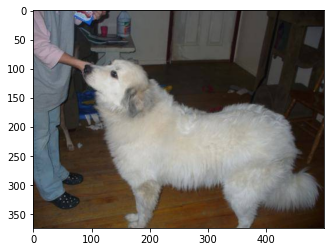

In [65]:
imagem = 'cachorro/dog.3531.jpg'
classificar_imagem(imagem)